In [9]:
import tifffile 
from matplotlib import pyplot as plt
#print('plt: ' + plt.__version__)
import cv2
print('cv2: ' + cv2.__version__)
import numpy as np
print('np: ' + np.__version__)
import math
import sys
import os

cv2: 4.1.0
np: 1.18.5


# Helper Functions

In [10]:
# The whole filter procedure as function:
# The image has to be square
# Option for the future: add pixel on the smaller side to make it square and crop after filtering
def filterImage(filterImg, highFrequ, lowFrequ):
    (x, y) = filterImg.shape
    if x != y:
        print('Error: Image is not quadratic!')
        return -1
    # set filter values
    rhigh = highFrequ # how narrower the window is
    rlow = lowFrequ
    ham = np.hamming(x)[:,None] # 1D hamming
    ham2dhigh = np.sqrt(np.dot(ham, ham.T)) ** rhigh # expand filterImage 2D hamming
    ham2dlow = np.sqrt(np.dot(ham, ham.T)) ** rlow
    ham2d = ham2dhigh - ham2dlow
    # check if image is square
    # calculate fourier transform
    f = cv2.dft(filterImg.astype('float32'), flags=cv2.DFT_COMPLEX_OUTPUT)
    # reorder result quarters
    f_shifted = np.fft.fftshift(f)
    f_complex = f_shifted[:,:,0]*1j + f_shifted[:,:,1]
    # apply filter mask
    f_filtered = ham2d * f_complex
    # reorder result
    f_filtered_shifted = np.fft.fftshift(f_filtered)
    inv_img = np.fft.ifft2(f_filtered_shifted) # inverse F.T.
    filtered_img = np.abs(inv_img)
    return filtered_img

In [119]:
def blurImage(img):
    """Applies a median filter, then a Gaussian blur"""
    return cv2.GaussianBlur(cv2.medianBlur(img,5), (5,5), 0)

In [11]:
# image alignment usingg Enhanced Correlation Coefficient Maximization
# returns the warp_matrix
# use cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP) to align

def eccImagesMat(im1_gray, im2_gray):
    # prefilter Images, helps to correlate
    # for best performance a filter which keeps good features to align should be used.
    # for example: with strong differences in brightnes but identical edges an edge dector can be used to filter.
    
    # Find size of image1
    sz = im1_gray.shape

    # Define the motion model (more freedom needs more computational time)
    # Translation, Euclidean, Affine, Homography
    warp_mode = cv2.MOTION_AFFINE
    
    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 10000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    # (precision vs computational time)
    termination_eps = 1e-5;
 
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
    #if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        #im2_aligned = cv2.warpPerspective (im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    #else :
        # Use warpAffine for Translation, Euclidean and Affine
        #im2_aligned = cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    return warp_matrix

In [12]:
def mergeWarpMatrix(firstMat, secondMat):
    firstMul = np.identity(3)
    secondMul = np.identity(3)
    (x, y) = firstMat.shape
    if x < 3:
        firstMul[0:2,:] = firstMat
    else:
        firstMul = firstMat
    (x, y) = secondMat.shape
    if x < 3:
        secondMul[0:2,:] = secondMat
    else:
        firstMul = secondMat
    combinedMat = secondMul.dot(firstMul)
    return combinedMat[0:2,:]

In [13]:
def alignSeries(stackToAlign, secondaryStack):
    # align volumen
    centerPlane = int(stackToAlign.shape[0]/2)
    #alignedFilterVol = np.empty_like(stackToAlign)
    alignedRawVol = np.empty_like(stackToAlign)
    secondAligned = np.empty_like(secondaryStack)
    #matrix = [None]
    warpMat = np.identity(3)[0:2,:]
    sz = stackToAlign[0].shape
    #alignedFilterVol[centerPlane] = filterImage(stackToAlign[centerPlane])
    alignedRawVol[centerPlane] = stackToAlign[centerPlane]
    secondAligned[centerPlane] = secondaryStack[centerPlane]
    offset = 0
    for i in range(centerPlane,0,-1):
        try:
            warpNew = eccImagesMat(cv2.bilateralFilter(filterImage(stackToAlign[i+offset],2,5000).astype('float32'), d=9, sigmaColor=50, sigmaSpace=3),\
                                   cv2.bilateralFilter(filterImage(stackToAlign[i-1],2,5000).astype('float32'), d=9, sigmaColor=50, sigmaSpace=3))
        except:
            try:
                warpNew = eccImagesMat(cv2.bilateralFilter(filterImage(filterImage(stackToAlign[i+offset],2,5000),2,5000), d=9, sigmaColor=50, sigmaSpace=3),\
                                       cv2.bilateralFilter(filterImage(filterImage(stackToAlign[i-1],2,5000),2,5000), d=9, sigmaColor=50, sigmaSpace=3))
            except:
                try:
                    warpNew = eccImagesMat(cv2.bilateralFilter(src=stackToAlign[i+offset].astype('float32'), d=9, sigmaColor=50, sigmaSpace=3),\
                                           cv2.bilateralFilter(src=stackToAlign[i-1].astype('float32'), d=9, sigmaColor=50, sigmaSpace=3))
                except cv2.error as e:
                    print("Oops! ", e)
                    print("at Image: ", i)
                    offset += 1
                    continue
        offset = 0
        warpMat = mergeWarpMatrix(warpMat, warpNew)
        #alignedFilterVol[i-1] = cv2.warpAffine(filterImage(stackToAlign[i-1],2,5000), warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        alignedRawVol[i-1] = cv2.warpAffine(stackToAlign[i-1], warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        secondAligned[i-1] = cv2.warpAffine(secondaryStack[i-1], warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    warpMat = np.identity(3)[0:2,:]
    for i in range(centerPlane,(stackToAlign.shape[0]-1)):
        try:
            warpNew = eccImagesMat(filterImage(stackToAlign[i-offset],2,5000), filterImage(stackToAlign[i+1],2,5000))
        except:
            try:
                warpNew = eccImagesMat(filterImage(filterImage(stackToAlign[i-offset],2,5000),2,5000),\
                                       filterImage(filterImage(stackToAlign[i+1],2,5000),2,5000))
            except:
                try:
                    warpNew = eccImagesMat(cv2.bilateralFilter(src=stackToAlign[i-offset].astype('float32'), d=9, sigmaColor=50, sigmaSpace=3),\
                                           cv2.bilateralFilter(src=stackToAlign[i+1].astype('float32'), d=9, sigmaColor=50, sigmaSpace=3))
                except cv2.error as e:
                    print("Oops! ", e)
                    print("at Image: ", i)
                    offset += 1
                    continue
        offset = 0
        warpMat = mergeWarpMatrix(warpMat, warpNew)
        #alignedFilterVol[i+1] = cv2.warpAffine(filterImage(stackToAlign[i+1]), warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        alignedRawVol[i+1] = cv2.warpAffine(stackToAlign[i+1], warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        secondAligned[i+1] = cv2.warpAffine(secondaryStack[i+1], warpMat, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return alignedRawVol, secondAligned

In [18]:
# imaige alignment
# this code uses feature detection (more robust solution down)
# to get better features, collect the points from different planes:

# maximum fetures to detect
# MAX_FEATURES = 1000
# take only the best x percent of matches
# GOOD_MATCH_PERCENT = 0.1

def alignImagesV(reference, toAlign, secondaryAlign, MAX_FEATURES=1000, GOOD_MATCH_PERCENT=0.1):
    """Aligns images within a volume after bandpass-based filtering
    DEPRECATED
    
    Parameters
    ----------
    reference : 2d numpy array
        The reference image to align to
    
    toAlign : 3d numpy array
        The rest of the stack to align
    
    secondaryAlign : ???
    
    MAX_FEATURES : int, default=1000
        The number of features to detect for alignment
    
    GOOD_MATCH_PERCENT : float, default=0.1
        Percent of features to keep, as defined by distance from that feature to the closest neighbor
    
    """
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES) #MAX_FEATURES
    points1 = np.zeros((1, 2), dtype=np.float32)
    points2 = np.zeros((1, 2), dtype=np.float32)
    for k in range (0,5):
        for i in range(0,toAlign.shape[0]):
            if k == 0:
                im1Gray = cv2.fastNlMeansDenoising(src=reference[i].astype('uint8'));
                im2Gray = cv2.fastNlMeansDenoising(src=toAlign[i].astype('uint8'));
            elif k == 1:
                im1Gray = cv2.fastNlMeansDenoising(filterImage(reference[i],2,5000).astype('uint8'))
                im2Gray = cv2.fastNlMeansDenoising(filterImage(toAlign[i],2,5000).astype('uint8'))
            elif k == 2:
                im1Gray = cv2.bilateralFilter(reference[i].astype('float32'), d=9, sigmaColor=50, sigmaSpace=3)
                im2Gray = cv2.bilateralFilter(toAlign[i].astype('float32'), d=9, sigmaColor=50, sigmaSpace=3)
            else:
                print('no alignment: ', i)
                return np.zero_like(toAlign), np.zero_like(secondaryAlign)
            keypoints1, descriptors1 = orb.detectAndCompute(im1Gray.astype('uint8'), None)
            keypoints2, descriptors2 = orb.detectAndCompute(im2Gray.astype('uint8'), None)
            # Match features.
            matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
            #matcher = cv2.BFMatcher_create(normType =cv2.NORM_L2, crossCheck=True)
            try:
                matches = matcher.match(descriptors1, descriptors2, None)
            except:
                print('cant align: ', i)
                continue
    
            # Sort matches by score
            matches.sort(key=lambda x: x.distance, reverse=False)
            #m = 0
            #while (matches[m].distance < 55):
            #    if (m > len(matches)-2):
            #        break
            #    m += 1
            # Remove not so good matches
            #print(m, ': ', matches[m].distance)
            numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
            matches = matches[:numGoodMatches]
            #print(numGoodMatches)

            # Draw top matches
            #imMatches = cv2.drawMatches(im1Gray, keypoints1, im2Gray, keypoints2, matches, None)
            #plt.figure(figsize=(10,10))
            #plt.imshow(imMatches, interpolation=None)
            #plt.show()
        
            # Extract location of good matches
            tempPoints1 = np.zeros((len(matches), 2), dtype=np.float32)
            tempPoints2 = np.zeros((len(matches), 2), dtype=np.float32)
            for m, match in enumerate(matches):
                tempPoints1[m, :] = keypoints1[match.queryIdx].pt
                tempPoints2[m, :] = keypoints2[match.trainIdx].pt
            points1 = np.concatenate((points1, tempPoints1), axis=0)
            points2 = np.concatenate((points2, tempPoints2), axis=0)
        h = cv2.estimateRigidTransform(points2[1:], points1[1:], False)
        if not hasattr(h, 'shape'):
            print("tryOtherFilter!")
            continue
        else:
            break
    # Use homography
    height, width = reference[1].shape
    imReg1 = np.empty_like(toAlign)
    imReg2 = np.empty_like(secondaryAlign)
    for i in range(0,toAlign.shape[0]):
        if (h.shape[0] == 2):
            imReg1[i] = cv2.warpAffine(toAlign[i], h, (width, height))
            imReg2[i] = cv2.warpAffine(secondaryAlign[i], h, (width, height))
        else:
            imReg1[i] = cv2.warpPerspective(toAlign[i], h, (width, height))
            imReg2[i] = cv2.warpPerspective(secondaryAlign[i], h, (width, height))
    #warpNew = eccImagesMat(filterImage(np.max(reference, axis=0), 2, 5000), filterImage(np.max(imReg1, axis=0), 2, 5000))
    try: 
        warpNew =  eccImagesMat(cv2.bilateralFilter(filterImage(np.max(reference, axis=0),2,5000).astype('float32'), d=9, sigmaColor=50, sigmaSpace=3),\
                                cv2.bilateralFilter(filterImage(np.max(imReg1, axis=0),2,5000).astype('float32'), d=9, sigmaColor=50, sigmaSpace=3))
    except:
        try:
            warpNew = eccImagesMat(cv2.bilateralFilter(filterImage(filterImage(np.max(reference, axis=0),2,5000),2,5000), d=9, sigmaColor=50, sigmaSpace=3),\
                                   cv2.bilateralFilter(filterImage(filterImage(np.max(imReg1, axis=0),2,5000),2,5000), d=9, sigmaColor=50, sigmaSpace=3))
        except:
            try:
                warpNew = eccImagesMat(cv2.bilateralFilter(src=np.max(reference, axis=0).astype('float32'), d=9, sigmaColor=50, sigmaSpace=3),\
                                       cv2.bilateralFilter(src=np.max(imReg1, axis=0).astype('float32'), d=9, sigmaColor=50, sigmaSpace=3))
            except cv2.error as e:
                print('no ecc, Skipped!')
                return np.empty_like(toAlign), np.empty_like(secondaryAlign)
    for i in range(0,toAlign.shape[0]):
        imReg1[i] = cv2.warpAffine(imReg1[i], warpNew, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        imReg2[i] = cv2.warpAffine(imReg2[i], warpNew, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return imReg1, imReg2

In [171]:
# image alignment
# this code uses feature detection

def alignImagesByFeatures(reference, toAlign, MAX_FEATURES = 1000, GOOD_MATCH_PERCENT = 0.1, to_plot=False):
    """Aligns images within a volume after bandpass-based filtering
    
    Parameters
    ----------
    reference : 2d numpy array
        The reference image to align to
    
    toAlign : 2d numpy array
        Frame to be aligned
    
    MAX_FEATURES : int, default=1000
        The number of features to detect for alignment
    
    GOOD_MATCH_PERCENT : float, default=0.1
        Percent of features to keep, as defined by distance from that feature to the closest neighbor
    
    to_plot : bool, default=False
        Whether to plot the matched features
        
    Returns
    -------
    imReg : 2d numpy array
        The aligned version of input array 'toAlign'
    """
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES) #MAX_FEATURES
    
    # First, filter the images
    reference = blurImage(reference)
    toAlign = blurImage(toAlign)

    keypoints1, descriptors1 = orb.detectAndCompute(reference.astype('uint8'), None)
    keypoints2, descriptors2 = orb.detectAndCompute(toAlign.astype('uint8'), None)
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    # alternative mather to try:
    #matcher = cv2.BFMatcher_create(normType =cv2.NORM_L2, crossCheck=True)
    try:
        matches = matcher.match(descriptors1, descriptors2, None)
    except:
        print('no matches found!')
        return
    
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    # decrease the number of matches by a given fraction
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    #print(numGoodMatches)

    if to_plot:
        # Draw top matches
        imMatches = cv2.drawMatches(reference.astype('uint8'), keypoints1, toAlign.astype('uint8'), keypoints2, matches, None)
        plt.figure(figsize=(10,10))
        plt.imshow(imMatches, interpolation=None)
        plt.show()
    
    # create empty arrays to store the matched point coordinates
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    # get the point coordinates
    for m, match in enumerate(matches):
        points1[m, :] = keypoints1[match.queryIdx].pt
        points2[m, :] = keypoints2[match.trainIdx].pt
    h, inliers = cv2.estimateAffinePartial2D(points2, points1, method=cv2.RANSAC, ransacReprojThreshold=2.0, confidence=0.99)

    # get size of images
    height, width = reference.shape
    imReg = np.empty_like(toAlign)
    # check if there is a warp matrix
    if not hasattr(h, 'shape'):
        print("no transformation found!")
        return imReg
    imReg = cv2.warpAffine(toAlign, h, (width, height))#, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
#     if (h.shape[0] == 2):
#         imReg = cv2.warpAffine(toAlign, h, (width, height))#, flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
#     else:
#         imReg = cv2.warpPerspective(toAlign, h, (width, height))
    return imReg

In [172]:
def alignVolume(volume, reference_slice, alignment_function = alignImagesByFeatures):
    """ Aligns a full volume via pair-wise feature matching between slices
    
    Parameters
    ----------
    volume : numpy 3d array
        Full volume to be aligned, with shape ZXY
    
    reference_slice : int
        Slice to use as the reference. All other slices will be aligned to this one
    
    alignment_function : function, default=alignImagesByFeatures
        Function with the signature:  aligned = f(reference, toAlign)
    
    
    Returns
    -------
    aligned_volume : numpy 3d array
        Aligned full volume
    """
    
    num_frames = volume.shape[0]
    ref = volume[reference_slice, ...]
    aligned_volume = np.empty_like(volume)
    
    for i in range(num_frames):
        if i == reference_slice:
            continue
#         print(f"Aligning frame {i}/{num_frames}")
        aligned_volume[i,...] = alignment_function(volume[i,...], ref)
    
    return aligned_volume
        

In [173]:
def plot_max_projections(v1, v2):
    """Plots the max projection of two volumes for comparison"""
    
    plt.figure(figsize=(18,18))
    plt.subplot(121)
    plt.imshow(np.max(v1,axis=0))#, vmin=80, vmax=400, interpolation=None)
    plt.subplot(122)
    plt.imshow(np.max(v2,axis=0))#, vmin=80, vmax=400, interpolation=None)
    plt.show()

# Aligning mCherry video

In [174]:
folder_name = '/users/charles.fieseler/test_worm1_data/mCherry/'
fname = 'test_100frames.ome.tiff'
fname = os.path.join(folder_name, fname)

# all_volumes = tifffile.imread(fname)
v1 = all_volumes[0,10:-10,...] # Take intermediate, higher quality frames

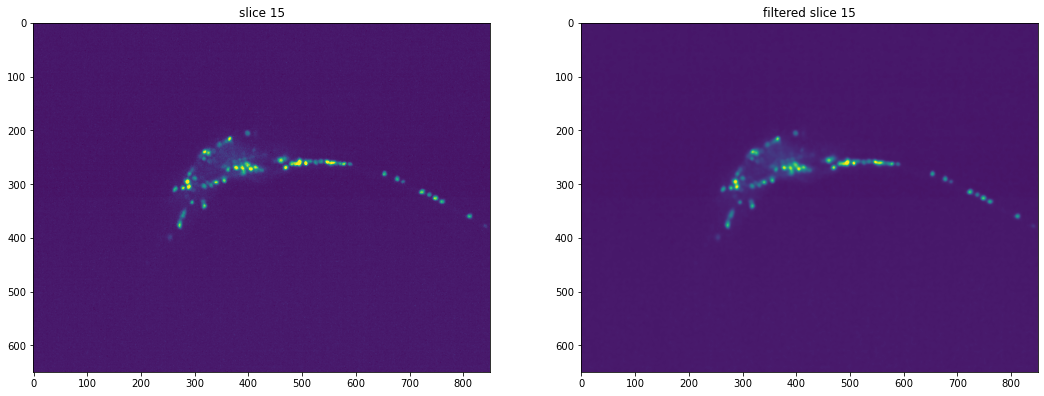

In [175]:
# test filter
ref_slice = 15
toAlign_slice = 16

plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(v1[ref_slice], vmin=80, vmax=400, interpolation=None)
plt.title(f"slice {ref_slice}")
plt.subplot(1,2,2)
plt.imshow(blurImage(v1[ref_slice]), vmin=80, vmax=400, interpolation=None)
plt.title(f"filtered slice {ref_slice}")
plt.show()

In [180]:
f = lambda ref, v : alignImagesByFeatures(ref, v, MAX_FEATURES = 1000, GOOD_MATCH_PERCENT = 0.1, to_plot=False)
aligned_volume = alignVolume(v1, 9, alignment_function=f)

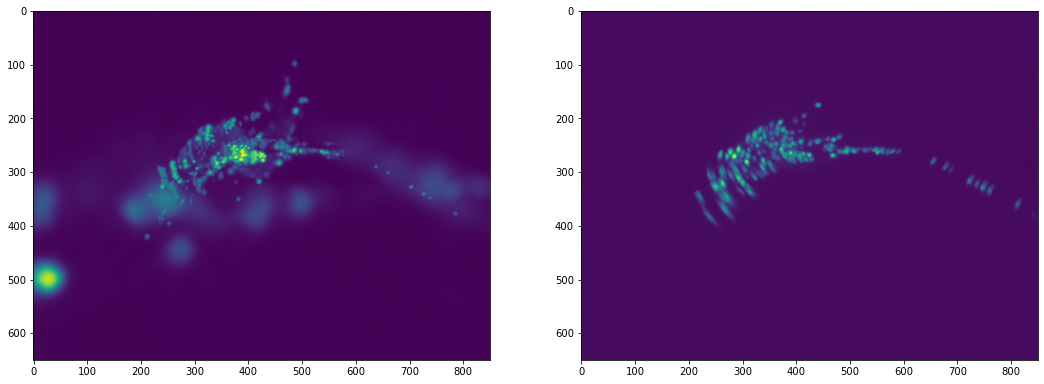

In [181]:
plot_max_projections(aligned_volume, v1)

In [91]:
aligned_volume.shape

(19, 650, 850)

# Example with RIS neurite

In [42]:
img1 = tifffile.imread('/groups/zimmer/shared_projects/MaraFMDataExamplesForLukas_Allignment/0828_w2/20190828_w2_C/p1/Gdual1-GFP-mCherry-DV-470+585LED--454-488Ex+558-585Ex-Add.stk')
print(img1.shape)
img2 = tifffile.imread('/groups/zimmer/shared_projects/MaraFMDataExamplesForLukas_Allignment/0828_w2/20190828_w2_C/p1/Cdual2-GFP-mCherry-DV-470+585LED--454-488Ex+558-585Ex-Add.stk')
print(img2.shape)

KeyboardInterrupt: 

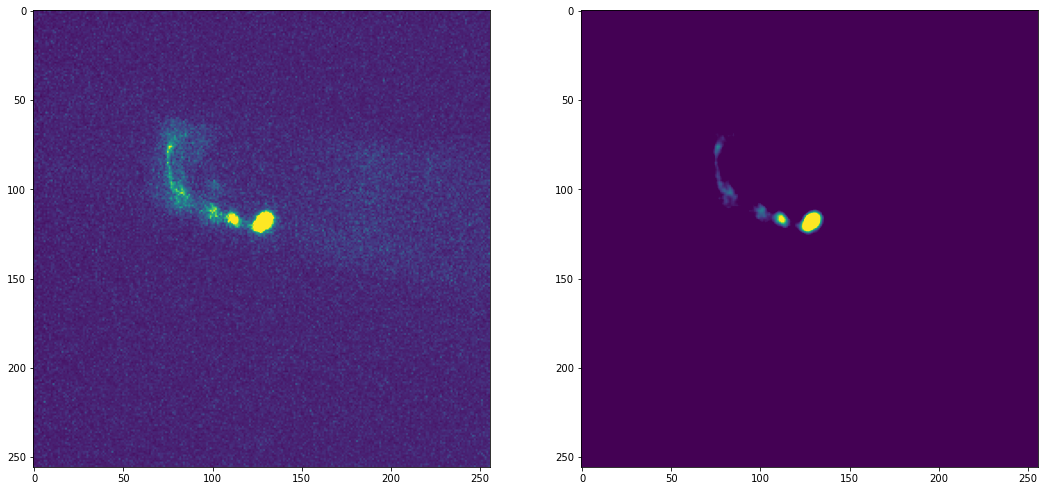

In [9]:
# test filter
plane=9280
plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(img2[plane], vmin=80, vmax=400, interpolation=None)
plt.subplot(1,2,2)
plt.imshow(filterImage(img2[plane],2,5000), vmin=80, vmax=400, interpolation=None)
plt.show()

In [26]:
# aligning the full time series
# alignment in chuncks of 100 images
# aligning the chuns with feature detection
totalImages = img2.shape[0]
startingPoint = 300
totalImages = 5000
result1 = np.empty_like(img1)
result2 = np.empty_like(img2)
firstImage = True
for c in range (startingPoint, totalImages, +100):
    print('Processing Chunk: ', c)
    try:
        resRaw2, resRaw1 = alignSeries(img2[c:c+100],img1[c:c+100])
    except:
        print('skipped Chunk: ', c)
        continue
    # align results with first chunk
    if firstImage:
        result1[c:c+100] = resRaw1
        result2[c:c+100] = resRaw2
        firstStack = np.empty_like(resRaw2)
        firstStack = resRaw2
        firstImage = False
    else:
        resAligned2, resAligned1 = alignImagesV(firstStack, resRaw2, resRaw1) 
        result1[c:c+100] = resAligned1
        result2[c:c+100] = resAligned2

Processing Chunk:  300
Processing Chunk:  400
Processing Chunk:  500
Processing Chunk:  600
Processing Chunk:  700
Processing Chunk:  800
Processing Chunk:  900
Processing Chunk:  1000
Processing Chunk:  1100
Processing Chunk:  1200
Processing Chunk:  1300
Processing Chunk:  1400
Processing Chunk:  1500
Processing Chunk:  1600
Processing Chunk:  1700
Processing Chunk:  1800
Processing Chunk:  1900
Processing Chunk:  2000
Processing Chunk:  2100
Processing Chunk:  2200
Processing Chunk:  2300
Processing Chunk:  2400
Processing Chunk:  2500
Processing Chunk:  2600
Processing Chunk:  2700
Processing Chunk:  2800
tryOtherFilter!
tryOtherFilter!
tryOtherFilter!
no alignment:  0


AttributeError: module 'numpy' has no attribute 'zero_like'

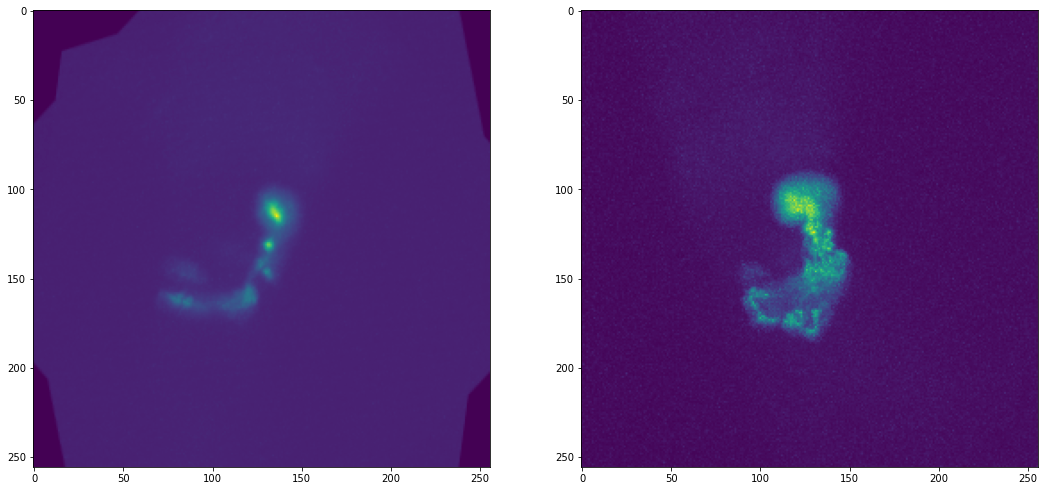

In [24]:
# show max intensity projection
point = 3000
firstP = point
secondP = point+100
im_MAX_aligned= np.max(result2[2900:secondP], axis=0) # scip first 3 images
im_MAX_orig= np.max(img2[firstP:secondP], axis=0) # scip first 3 images
plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.imshow(im_MAX_aligned, interpolation=None)
plt.subplot(1,2,2)
plt.imshow(im_MAX_orig, interpolation=None)
plt.show()

In [80]:
resAligned2, resAligned1 = alignImagesV(firstStack[50:52], resRaw2[50:52], resRaw1[50:52])

89 :  55.0
58
70 :  55.0
51
